In machine learning, the train-dev-test split is a common technique used to evaluate the performance of a model and prevent overfitting. The dataset is divided into three subsets: the training set, the development (or validation) set, and the test set.

The benchmark comprises 8628 sentence pairs. This is the breakdown according to genres and train-dev-test splits:

                train  dev test total 
        -----------------------------
        news     3299  500  500  4299
        caption  2000  625  525  3250
        forum     450  375  254  1079
        -----------------------------
        total    5749 1500 1379  8628

In [34]:
import pandas as pd
import numpy as np
from numpy import arccos
import nltk
nltk.download("punkt")
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from string import punctuation
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
from unidecode import unidecode
!pip install -U spacy
import spacy
import sys
!{sys.executable} -m spacy download en_core_web_sm
spacy_nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                              0.0/12.8 MB ? eta -:--:--
     -                                        0.5/12.8 MB 14.9 MB/s eta 0:00:01
     ---                                      1.1/12.8 MB 11.3 MB/s eta 0:00:02
     ----                                     1.6/12.8 MB 12.7 MB/s eta 0:00:01
     ------                                   2.2/12.8 MB 11.6 MB/s eta 0:00:01
     --------                                 2.7/12.8 MB 12.4 MB/s eta 0:00:01
     ----------                               3.2/12.8 MB 12.2 MB/s eta 0:00:01
     ------------                             3.9/12.8 MB 11.7 MB/s eta 0:00:01
     -------------                            4.4/12.8 MB 12.2 MB/s eta 0:00:01
     ---------------                          5.0/12.8 MB 11.7 MB/s eta 0:00:01
     -----------------                        5.5/12.8 MB 11.7 MB/s eta 0:00:01
     ------------------                       6.0/12.8 MB 11.7 MB/s eta 0:00:01
     --------------------                     6.

In [3]:
def on_bad_line(values):
    return values[:7]

columns_mapping = {
    0: 'genre',
    1: 'filename',
    2: 'year',
    3: 'index',
    4: 'score',
    5: 'sentence1',
    6: 'sentence2'
}

# quotings 3 = csv.QUOTE_NONE
df = pd.read_csv('Dataset/sts-train.csv', sep="\t", on_bad_lines=on_bad_line, engine='python', header=None, encoding='utf-8', quoting=3).rename(columns=columns_mapping)
print(f'shape of the Dataframe {df.shape}')
df.head(10)

shape of the Dataframe (5749, 7)


,genre,filename,year,index,score,sentence1,sentence2
0,main-captions,MSRvid,2012test,1,5.00,A plane is taking off.,An air plane is taking off.
1,main-captions,MSRvid,2012test,4,3.80,A man is playing a large flute.,A man is playing a flute.
2,main-captions,MSRvid,2012test,5,3.80,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...
3,main-captions,MSRvid,2012test,6,2.60,Three men are playing chess.,Two men are playing chess.
4,main-captions,MSRvid,2012test,9,4.25,A man is playing the cello.,A man seated is playing the cello.
5,main-captions,MSRvid,2012test,11,4.25,Some men are fighting.,Two men are fighting.
6,main-captions,MSRvid,2012test,12,0.50,A man is smoking.,A man is skating.
7,main-captions,MSRvid,2012test,13,1.60,The man is playing the piano.,The man is playing the guitar.
8,main-captions,MSRvid,2012test,14,2.20,A man is playing on a guitar and singing.,A woman is playing an acoustic guitar and sing...
9,main-captions,MSRvid,2012test,16,5.00,A person is throwing a cat on to the ceiling.,A person throws a cat on the ceiling.


In [4]:
sentences1 = df["sentence1"]
sentences2 = df["sentence2"]
sentences_list = np.unique(np.concatenate((np.ravel(sentences1.values),np.ravel(sentences2.values))))

print(f"Total number of sentences: {len(sentences_list)}")

Total number of sentences: 10566


In [5]:
def remove_special_chars(text):
    regex = '[' + punctuation + ']'
    return re.sub(regex,'',unidecode(text)).lower()

def remove_stop_words(text):
    stop_words = stopwords.words('english')
    return ' '.join([word for word in text.split() if word not in stop_words])

def lemmatize(text):
    parsed_sentence = spacy_nlp(str(text))
    lemmatized_sentence = ' '.join([word.lemma_ for word in parsed_sentence])
    return lemmatized_sentence

#TODO mostrare differenze tra originale e lemmatizzazione


no_punct_sentences_list = np.array([remove_special_chars(string) for string in sentences_list])
clean_sentences_list = np.array([remove_stop_words(string) for string in no_punct_sentences_list])
lemmatized_sentences_list = np.array([remove_stop_words(lemmatize(remove_special_chars(sentence)).lower()) for sentence in clean_sentences_list])



print(sentences_list[:5])
print(clean_sentences_list[:5])
print(lemmatized_sentences_list[:5])

[' - Income, top rate:  percent.' ' Foxe was mostly frozen.'
 " billion . Everyone in the world at Mexico's current prosperity level."
 ' warmed.C from the year prior.'
 '"Americans don\'t cut and run, we have to see this misadventure through," she said.']
['income top rate percent' 'foxe mostly frozen'
 'billion everyone world mexicos current prosperity level'
 'warmedc year prior' 'americans dont cut run see misadventure said']
['income top rate percent' 'foxe mostly frozen'
 'billion everyone world mexicos current prosperity level'
 'warmedc year prior' 'americans cut run see misadventure say']


In [5]:
array_len = np.vectorize(len)(sentences_list)
mean_len = np.mean(array_len)
print(f"Mean length of sentences in characters: {mean_len:.2f}")

Mean length of sentences in characters: 59.37


Maximum sentence length: 56
Minimum sentence length: 2
Mean length of sentences in words: 10.17


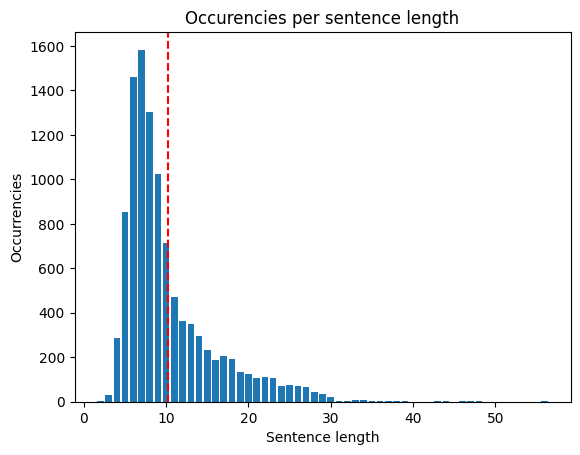

In [6]:
arr_words = np.array([len(s.split()) for s in sentences_list])

print(f"Maximum sentence length: {np.max(arr_words)}")
print(f"Minimum sentence length: {np.min(arr_words)}")

mean_sentences_length = np.mean(arr_words);
print(f"Mean length of sentences in words: {mean_sentences_length:.2f}")

unique, counts = np.unique(arr_words, return_counts=True)

plt.bar(unique, counts)

plt.axvline(x=mean_sentences_length, color='r', linestyle='--')

plt.xlabel("Sentence length")
plt.ylabel("Occurrencies")
plt.title("Occurencies per sentence length")


plt.show()

In [7]:
words_with_duplicates = [word for string in no_punct_sentences_list for word in word_tokenize(string)]
words_nostopwords = [w for w in words_with_duplicates if w not in stopwords.words('english')]
counts_nostopwords = nltk.Counter(words_nostopwords)
counts_nostopwords.most_common(20)

[('man', 853),
 ('woman', 547),
 ('two', 458),
 ('said', 455),
 ('dog', 418),
 ('us', 402),
 ('white', 282),
 ('killed', 265),
 ('black', 258),
 ('playing', 254),
 ('percent', 253),
 ('new', 238),
 ('people', 217),
 ('syria', 211),
 ('china', 191),
 ('police', 173),
 ('running', 170),
 ('president', 168),
 ('person', 161),
 ('water', 156)]

In [8]:
vocabulary = np.unique(words_nostopwords)
print(len(vocabulary))
print(vocabulary)

12243
['0' '004' '005' ... 'zubaidi' 'zuccarini' 'zuma']


Mean scores of sentence similarity: 2.70


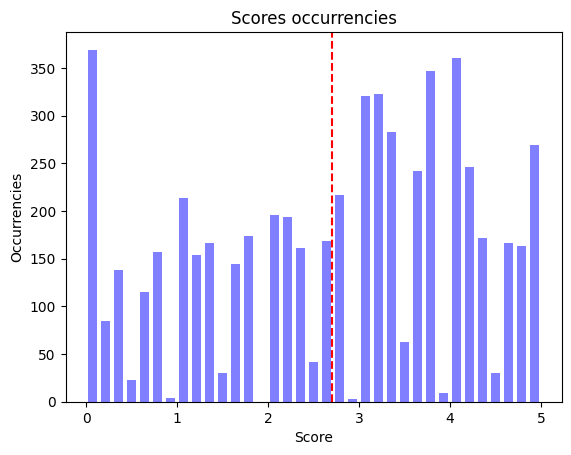

In [9]:
tot_scores = df["score"]
scores = np.ravel(tot_scores.values)

mean_scores = np.mean(scores);
print(f"Mean scores of sentence similarity: {mean_scores:.2f}")

plt.hist(scores, bins=35, alpha=0.5, color='blue', rwidth=0.7)

plt.axvline(x=mean_scores, color='r', linestyle='--')

plt.xlabel("Score")
plt.ylabel("Occurrencies")
plt.title("Scores occurrencies")

plt.show()

## Text Clustering

In [54]:
# creazione della matrice di similarità
tfidf = TfidfVectorizer(max_df=0.8, min_df=0, stop_words='english', strip_accents='ascii')
tfidf_matrix = tfidf.fit_transform(lemmatized_sentences_list)
vocab = tfidf.get_feature_names_out()

print(tfidf_matrix.shape)
print(vocab)

(10566, 9857)
['004' '005' '006' ... 'zubaidi' 'zuccarini' 'zuma']


In [55]:
word = 'dog'
word_id = tfidf.transform([word]).nonzero()[1]
filter = tfidf_matrix.getcol(word_id).nonzero()[0]
print(f'The word {word} is present in {len(filter)} documents. Here\'s the first 5:')
for idx, text in enumerate(no_punct_sentences_list[filter][:5]):
    print(str(idx + 1) + '.' , text)

The word dog is present in 517 documents. Here's the first 5:
1. a baby is playing with a dog
2. a baby plays with a dog and ball
3. a bear is running from two dogs
4. a black and a brown dog running in the grass
5. a black and a yellow dog


[[1.14046735 1.08209408 1.18268806 ... 1.04827455 1.09872832 1.0003299 ]
 [1.14046735 1.08209408 1.18268806 ... 1.04827455 1.09872832 1.00084739]
 [1.14046735 1.08209408 1.18268806 ... 1.04613295 1.09872832 0.9991366 ]
 ...
 [1.14046735 1.08209408 1.18268806 ... 1.04770756 1.0982164  0.99900267]
 [1.14046735 1.08128212 1.18268806 ... 1.04827455 1.09768281 0.99755638]
 [1.14046735 1.07957184 1.17825067 ... 1.04741062 1.09872832 0.99843948]]
[26 29 29 ...  3  3 29]


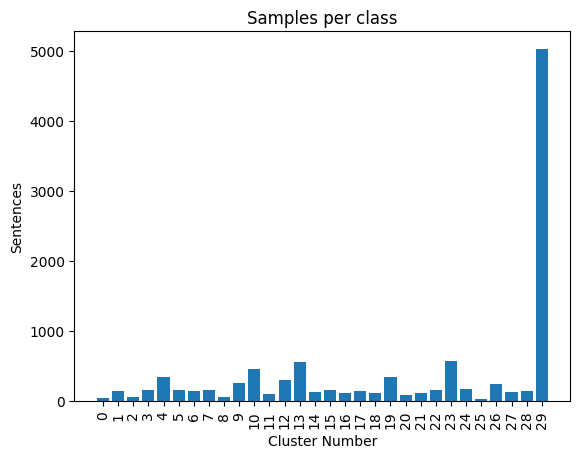

In [62]:
#TODO remove
k = 30
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
cluster_matrix = kmeans.fit_transform(tfidf_matrix)
print(cluster_matrix)
clusters = np.argmin(cluster_matrix, axis=-1)
print(clusters)

uniques, counts = np.unique(clusters, return_counts=True)
plt.bar(uniques, counts)
plt.xlabel('Cluster Number')
plt.ylabel('Sentences')
plt.xticks(uniques, rotation=90)
plt.title('Samples per class')
plt.show()

As we can see there is a very large cluster that might correspond to more common terms across the corpus. The other clusters though look well distributed

In [63]:
print("Top terms per cluster:")

for i in range(kmeans.n_clusters):
    centroid = kmeans.cluster_centers_[i]    
    sorted_terms = centroid.argsort()[::-1]
    print(f"Cluster {i}:\t{[vocab[j] for j in sorted_terms[:5]]}")

Top terms per cluster:
Cluster 0:	['sheep', 'stand', 'black', 'field', 'hill']
Cluster 1:	['sit', 'table', 'people', 'man', 'woman']
Cluster 2:	['dance', 'woman', 'man', 'group', 'rain']
Cluster 3:	['small', 'international', 'end', 'myanmar', 'state']
Cluster 4:	['dog', 'run', 'snow', 'grass', 'brown']
Cluster 5:	['stock', 'close', 'high', 'low', 'open']
Cluster 6:	['korea', 'south', 'north', 'korean', 'nuclear']
Cluster 7:	['attack', 'kill', 'iraq', 'suicide', 'bomb']
Cluster 8:	['chemical', 'weapon', 'syria', 'use', 'destroy']
Cluster 9:	['play', 'man', 'guitar', 'boy', 'piano']
Cluster 10:	['woman', 'slice', 'cut', 'man', 'meat']
Cluster 11:	['train', 'track', 'station', 'crash', 'dead']
Cluster 12:	['kill', 'afghanistan', 'soldier', 'bomb', 'suicide']
Cluster 13:	['say', 'official', 'police', 'spokesman', 'mr']
Cluster 14:	['pakistan', 'kill', 'drone', 'strike', 'taliban']
Cluster 15:	['person', 'slice', 'cut', 'piece', 'onion']
Cluster 16:	['cat', 'white', 'look', 'black', 'play']

In [66]:
np.array(lemmatized_sentences_list)[kmeans.labels_ == 25]

array(['brown dog run though river', 'dog catch fish river',
       'girl run along river bank two black dog',
       'group river barge tree background',
       'man go jump bike river background', 'man fishing river',
       'man bike nest river', 'white dog stand river shake dry',
       'aug 15 1982 remain chapman hind mill find green river',
       'british police arrest 21 people early tuesday connection suspect ritual murder african boy whose torso find thames river',
       'car plunge river us bridge collapse',
       'car driver plunge river wash i5 bridge collapse',
       'lawyer plan stay river start recede',
       'plan stay day river crest forecast late last night',
       'body find several week later green river',
       'india china ink agreement transborder river',
       'police arrest 21 people connection murder young nigerian child whose headless limbless torso find float river thame',
       'slide embankment two rescuer hit spongy rocky floor river immediately 

In [82]:
cluster_matrix[25, :]
(kmeans.labels_ - np.argmin(cluster_matrix, axis=-1)).sum()


0

In [89]:
tfidf_matrix[kmeans.labels_ == 3]

<158x9857 sparse matrix of type '<class 'numpy.float64'>'
	with 1331 stored elements in Compressed Sparse Row format>

In [99]:
# print the top 10 words in each cluster
for i in range(k):
    centroid = kmeans.cluster_centers_[i]    
    sorted_terms = centroid.argsort()[::-1]
    print(f"\nCluster {i} - {[vocab[j] for j in sorted_terms[:5]]}:")

    i_labelled_sentence_vectors = tfidf_matrix[kmeans.labels_ == i]
    i_labelled_sentences = np.array(lemmatized_sentences_list)[kmeans.labels_ == i]
    # sorting the terms to most similar to the centroid
    sorted_sentences = i_labelled_sentences[np.argsort(cosine_similarity(i_labelled_sentence_vectors, [centroid]).flatten())[::-1]]
    
    for idx, sentence in enumerate(sorted_sentences[:10]):
        print(str(idx + 1) + ") ",sentence)


Cluster 0 - ['sheep', 'stand', 'black', 'field', 'hill']:
1)  black white sheep walk next white sheep
2)  sheep stand tree
3)  group sheep field
4)  large dog stand next sheep field
5)  large sheep stand hill
6)  ten sheep look camera
7)  many sheep stand green hill
8)  group sheep hill
9)  white sheep stand green hill
10)  sheep stand near child

Cluster 1 - ['sit', 'table', 'people', 'man', 'woman']:
1)  four people sit table
2)  two people sit table restaurant
3)  group people sit around table food
4)  three man sit table drink
5)  group people sit restaurant table
6)  group people sit table restaurant
7)  man sit rock
8)  group people sit table drink
9)  three man suit sit table
10)  group elderly people sit around table

Cluster 2 - ['dance', 'woman', 'man', 'group', 'rain']:
1)  man dance
2)  man dance
3)  two man dance
4)  man dance
5)  three woman dance
6)  woman dance
7)  woman dance fire
8)  two woman dance
9)  man woman dance
10)  group man dance

Cluster 3 - ['small', 'int

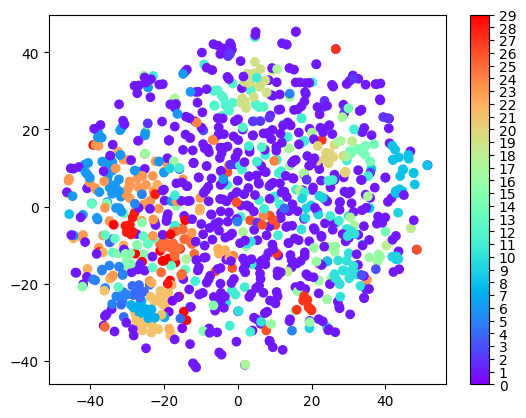

In [15]:
# visualize the clusters using manifold learning
from sklearn.manifold import TSNE
from matplotlib import ticker

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(tfidf_matrix.toarray()[::10])
# plot the clusters printng the color scale
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=clusters[::10], cmap='rainbow')
# (generate plot here)
cb = plt.colorbar()
tick_locator = ticker.MaxNLocator(nbins=30)
cb.locator = tick_locator
cb.update_ticks()
plt.show()


In [50]:
from gensim.models import Word2Vec
# import word tokenizer
from nltk.tokenize import word_tokenize

tokenized_corpus = [word_tokenize(w) for w in lemmatized_sentences_list]
word2vec_cluster_model = Word2Vec(tokenized_corpus, vector_size=100, min_count=4, window=5, negative=10, workers=4, sg=0, cbow_mean=1, epochs=150, seed=42)
print("vocabular size:", len(word2vec_cluster_model.wv.key_to_index))

vocabular size: 3121


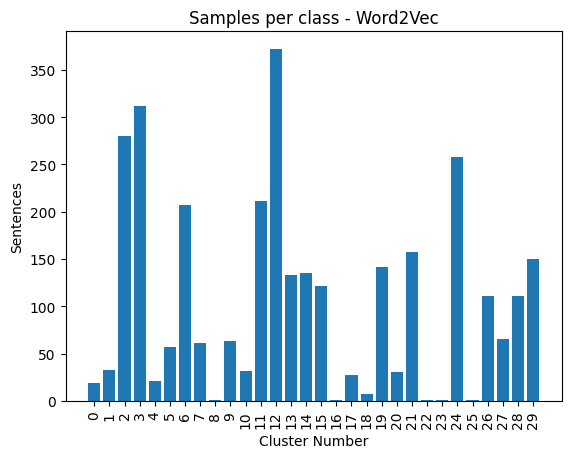

In [51]:
k = 30
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
cluster_matrix = kmeans.fit_transform(word2vec_cluster_model.wv.vectors)
clusters = np.argmin(cluster_matrix, axis=-1)

uniques, counts = np.unique(clusters, return_counts=True)
plt.bar(uniques, counts)
plt.xlabel('Cluster Number')
plt.ylabel('Sentences')
plt.xticks(uniques, rotation=90)
plt.title('Samples per class - Word2Vec')
plt.show()

In [52]:
print("Top terms per cluster:")

for i in range(kmeans.n_clusters):
    centroid = kmeans.cluster_centers_[i]    
    i_labelled_terms = np.array(word2vec_cluster_model.wv.index_to_key)[kmeans.labels_ == i]
    # sorting the terms to most similar to the centroid
    sorted_terms = i_labelled_terms[np.argsort(cosine_similarity(word2vec_cluster_model.wv[i_labelled_terms], [centroid]).flatten())[::-1]]
    print(f"Cluster {i}:\t{[w for w in sorted_terms[:10]]}")

Top terms per cluster:
Cluster 0:	['bomber', 'wound', 'suicide', 'kill', 'injure', 'bomb', 'least', 'gunman', 'militant', 'blast']
Cluster 1:	['year', 'month', 'week', 'seventh', 'colorado', 'miss', 'consecutive', 'recover', 'hour', 'home']
Cluster 2:	['chef', 'fry', 'cheese', 'boil', 'bread', 'tomato', 'tortilla', 'carrot', 'cucumber', 'dough']
Cluster 3:	['texans', 'usgs', 'snowboarder', 'eruption', 'cub', 'outfielder', 'coach', 'e', 'tornado', 'spree']
Cluster 4:	['midday', 'trading', 'usd', 'industrial', 'exchange', 'average', 'gain', 'yuan', 'euro', 'dow']
Cluster 5:	['research', 'director', 'department', 'organization', 'medical', 'scientific', 'regional', 'institute', 'task', 'chairman']
Cluster 6:	['kennedy', 'lawyer', 'absolutely', 'jim', 'martin', 'rehabilitation', 'prosecutor', 'internal', 'describe', 'certainly']
Cluster 7:	['peaceful', 'cooperation', 'nonproliferation', 'proliferation', 'energy', 'biological', 'prevent', 'enhance', 'program', 'initiative']
Cluster 8:	['gov

## Topic Models

In [107]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(stop_words='english',min_df=5,max_df=.5)
count_matrix = count_vectorizer.fit_transform(lemmatized_sentences_list)
count_vocab = count_vectorizer.get_feature_names_out()

In [108]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=30, verbose=0, learning_method='online', max_iter=30)
lda.fit(count_matrix)

iteration: 1 of max_iter: 30
iteration: 2 of max_iter: 30
iteration: 3 of max_iter: 30
iteration: 4 of max_iter: 30
iteration: 5 of max_iter: 30
iteration: 6 of max_iter: 30
iteration: 7 of max_iter: 30
iteration: 8 of max_iter: 30
iteration: 9 of max_iter: 30
iteration: 10 of max_iter: 30
iteration: 11 of max_iter: 30
iteration: 12 of max_iter: 30
iteration: 13 of max_iter: 30
iteration: 14 of max_iter: 30
iteration: 15 of max_iter: 30
iteration: 16 of max_iter: 30
iteration: 17 of max_iter: 30
iteration: 18 of max_iter: 30
iteration: 19 of max_iter: 30
iteration: 20 of max_iter: 30
iteration: 21 of max_iter: 30
iteration: 22 of max_iter: 30
iteration: 23 of max_iter: 30
iteration: 24 of max_iter: 30
iteration: 25 of max_iter: 30
iteration: 26 of max_iter: 30
iteration: 27 of max_iter: 30
iteration: 28 of max_iter: 30
iteration: 29 of max_iter: 30
iteration: 30 of max_iter: 30


LatentDirichletAllocation(learning_method='online', max_iter=30,
                          n_components=30, verbose=1)

In [105]:
count_matrix

<10566x2428 sparse matrix of type '<class 'numpy.int64'>'
	with 51366 stored elements in Compressed Sparse Row format>

In [109]:
for i in range(len(lda.components_)):
    sorted_terms = lda.components_[i].argsort()[::-1]
    concatenated_terms = '[' + ', '.join(count_vocab[i] for i in sorted_terms[:10]) + ']'
    print (f'Topic {i + 1}:\t', concatenated_terms)

Topic 1:	 [dog, run, brown, cut, high, jump, grass, beach, black, remain]
Topic 2:	 [company, house, thursday, number, piece, executive, say, james, conventional, earning]
Topic 3:	 [ride, dog, walk, snow, field, issue, black, reach, cow, eat]
Topic 4:	 [dead, slice, police, small, ukraine, east, trade, boat, 30, gunman]
Topic 5:	 [sit, world, look, camera, fall, sheep, good, chair, way, cover]
Topic 6:	 [state, people, group, egypt, vote, protest, include, tuesday, presidential, worker]
Topic 7:	 [official, green, big, computer, seek, council, say, decline, floor, meat]
Topic 8:	 [play, government, boy, week, street, sale, guitar, ball, american, senate]
Topic 9:	 [china, afghanistan, minister, nato, palestinian, little, troop, indian, road, french]
Topic 10:	 [man, rise, horse, dance, work, continue, lead, onion, night, pour]
Topic 11:	 [person, tell, officer, hand, miss, family, demand, john, thousand, like]
Topic 12:	 [white, close, black, cat, sign, treaty, law, table, chemical, s

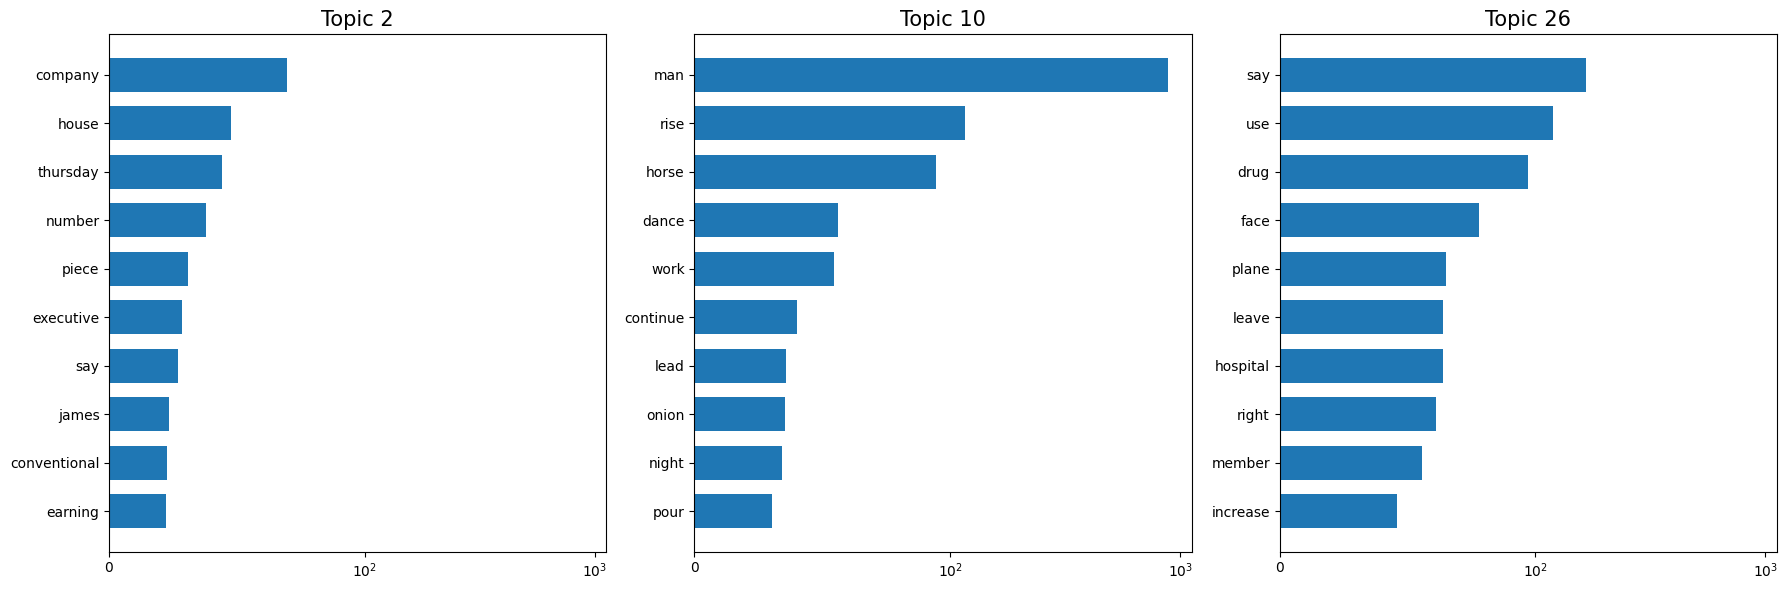

In [150]:
num_words = 10
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True)
topic_indices = [1, 9, 25]

for i, topic_idx in enumerate(topic_indices):
    topic = lda.components_[topic_idx]
    top_terms_index = topic.argsort()[:-num_words - 1:-1]
    top_terms = [count_vocab[i] for i in top_terms_index]
    weights = topic[top_terms_index]
    ax = axes[i]
    ax.barh(top_terms, weights, height=0.7)
    ax.set_title(f'Topic {topic_idx + 1}', fontdict={'fontsize': 15})
    ax.invert_yaxis()
    ax.set_xscale('symlog', linthresh=100)

plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.20, hspace=0.3)
plt.tight_layout()
plt.show()


# Training models
We now deal with the task of sentence similarity, employing models already seen like TF-IDF and Word2Vec as well as other approaches such as Transformers

## Bag of Words

We just trained a tf-idf model to compute clusters. We can also use this model to compute similarity between sentences using a bag of words approach.

In [18]:
def train_tfidf_vectorizer(sentences_list, max_df=0.8, min_df=5, remove_stopwords=True, ngram_range=(1,1)):
    """
    Train a TF-IDF vectorizer on the given sentences list.
    
    max_df: ignore terms that appear in more than max_df of the documents
    min_df: ignore terms that appear in less than min_df of the documents
    remove_stopwords: remove stopwords from the sentences
    preprocess_sentence: function to preprocess each sentence
    ngram_range: range of ngrams to consider
    """

    # Define TF-IDF Vectorizer
    tfidf = TfidfVectorizer(
        max_df=max_df, min_df=min_df, 
        stop_words='english' if remove_stopwords else None, 
        strip_accents='ascii',
        ngram_range=ngram_range
    )

    # Fit the vectorizer on the sentences and compute the TF-IDF matrix
    tfidf_matrix = tfidf.fit_transform(sentences_list)
    tfidf_vocab = tfidf.get_feature_names_out()

    # Analyze results
    print(f"The dataset contains {len(tfidf_vocab)} terms")
    np.random.seed(41)
    random_sentence = np.random.choice(sentences_list)
    print("Random sentence:", random_sentence)
    random_sentence_tfidf_scores = tfidf.transform([random_sentence])
    sentence_df = pd.DataFrame({
        "id": random_sentence_tfidf_scores.nonzero()[1],
        "word": tfidf_vocab[random_sentence_tfidf_scores.nonzero()[1]],
        "scores": random_sentence_tfidf_scores.data
    })
    print(sentence_df.head())

    return tfidf, tfidf_matrix

In [19]:
def evaluate_mse(model: TfidfVectorizer, dataset: pd.DataFrame):
    predicted_scores = []
    for idx, row in dataset.iterrows():
        a = row["sentence1"]
        b = row["sentence2"]
        vectorized_sentences = model.transform([a, b])
        similarity = cosine_similarity(vectorized_sentences)
        predicted_scores.append(similarity[0][1])

    return mean_squared_error(dataset["score"].values, predicted_scores)

In [26]:
clean_dataset = pd.DataFrame({
    'sentence1': df['sentence1'].map(remove_special_chars).map(remove_stop_words),
    'sentence2': df['sentence2'].map(remove_special_chars).map(remove_stop_words),
    'score': df['score'] / 5
})

tfidf_vectorizer, tfidf_matrix = train_tfidf_vectorizer(clean_sentences_list, min_df=0)

NameError: name 'train_tfidf_vectorizer' is not defined

Now we print the most similar sentences of a selected one using cosine similarity, showing the original ones


In [21]:
tfidf_similarity = cosine_similarity(tfidf_matrix)
tfidf_sentence_idx = 10
print(sentences_list[tfidf_sentence_idx])
for i, col_idx in enumerate(tfidf_similarity[tfidf_sentence_idx].argsort()[::-1][1:6]):
    print(str(i+1) + ")",f"{tfidf_similarity[tfidf_sentence_idx][col_idx]:.2f}", sentences_list[col_idx])

"Biotech products, if anything, may be safer than conventional products because of all the testing," said Robert Fraley, Monsanto's executive vice president.
1) 0.68 "Biotech products, if anything, may be safer than conventional products because of all the testing," Fraley said, adding that 18 countries have adopted biotechnology.
2) 0.27 Products featuring Vanderpool will be released within five years, he said.
3) 0.23 As executive vice president of new ventures, Elias will report to Joe Tucci, EMC's president and chief executive.
4) 0.20 The third appointment was to a new job, executive vice president and chief staff officer.
5) 0.20 Chinese president meets Indian vice president


In [22]:
print("MSE:", evaluate_mse(tfidf_vectorizer, clean_dataset))

MSE: 0.05174592726147045


We try to improve it using trigrams

In [23]:
trigrams_tfidf_vectorizer, _ = train_tfidf_vectorizer(clean_sentences_list, ngram_range=(1,3), min_df=2)
print("MSE:", evaluate_mse(trigrams_tfidf_vectorizer, clean_dataset))
#TODO cercare su internet comparazione performance bigrammi monogrammi

The dataset contains 21599 terms
Random sentence: person hitchhiking road
      id    word    scores
0  16397    road  0.773089
1  14211  person  0.634297
MSE: 0.06786084296557404


we try to improve by handling numbers

In [24]:
def substitute_number(sentence):
    return re.sub(r'\d+', ' number ', sentence)

In [25]:
no_number_dataset = pd.DataFrame({
    'sentence1': clean_dataset['sentence1'].map(substitute_number),
    'sentence2': clean_dataset['sentence2'].map(substitute_number),
    'score': clean_dataset['score']
})

#TODO mostrare differenze tra originale e con [number]
no_number_sentences_list = [substitute_number(sentence) for sentence in clean_sentences_list]

number_tfidf_vectorizer, number_tfidf_matrix = train_tfidf_vectorizer(no_number_sentences_list, min_df=0)
print("MSE:", evaluate_mse(number_tfidf_vectorizer, no_number_dataset))

The dataset contains 11250 terms
Random sentence: person hitchhiking road
     id         word    scores
0  8458         road  0.502688
1  7303       person  0.412441
2  4602  hitchhiking  0.759735
MSE: 0.05452352749923701


we try to improve by lemmatizing the sentences

In [28]:
lemmatized_dataset = pd.DataFrame({
    'sentence1': clean_dataset['sentence1'].map(lemmatize),
    'sentence2': clean_dataset['sentence2'].map(lemmatize),
    'score': clean_dataset['score']
})

In [31]:
lemmatized_tfidf_vectorizer, _ = train_tfidf_vectorizer(lemmatized_sentences_list, min_df=0)
print("MSE:", evaluate_mse(lemmatized_tfidf_vectorizer, lemmatized_dataset))

The dataset contains 9859 terms
Random sentence: person hitchhike road
     id       word    scores
0  7623       road  0.500708
1  6762     person  0.411840
2  4458  hitchhike  0.761366
MSE: 0.04651429476482215


In [32]:
# Saving the lemmatized sentences to a txt file
with open('Dataset/lemmatized_sentences.txt', 'w') as f:
    for item in lemmatized_sentences_list:
        f.write("%s\n" % item)

## Word2Vec

In [33]:
from gensim.models import Word2Vec

In [34]:
analyzer = lemmatized_tfidf_vectorizer.build_analyzer()
tokenized_corpus = [analyzer(w) for w in lemmatized_sentences_list]
model = Word2Vec(tokenized_corpus, vector_size=100, min_count=4, window=5, negative=10, workers=4, sg=0, cbow_mean=1, epochs=150, seed=42)
print("vocabular size:", len(model.wv.key_to_index))

#print most similar words to
for item in ['car', 'boy', 'man', 'girl', 'woman', 'obama', 'florida', 'cat', 'dog', 'blue', 'kill', 'bomb', 'piano', 'pizza', 'italy']:
    print(item, '-->', [w for w, s in model.wv.most_similar(item)])

vocabular size: 2995
car --> ['roadside', 'vehicle', 'bicycle', 'amusement', 'motorcycle', 'train', 'pole', '19', 'drain', 'nightclub']
boy --> ['kid', 'girl', 'child', 'garden', 'man', 'baby', 'puppy', 'jacket', 'woman', 'kitten']
man --> ['woman', 'girl', 'person', 'dog', 'guy', 'boy', 'gray', 'white', 'suit', 'pink']
girl --> ['woman', 'man', 'hat', 'boy', 'shirt', 'jacket', 'suit', 'dog', 'wear', 'blue']
woman --> ['man', 'girl', 'lady', 'person', 'suit', 'gray', 'hat', 'banana', 'counter', 'short']
obama --> ['rebuild', 'obamas', 'depend', 'clinton', 'religion', 'arms', 'hollande', 'temporarily', 'gop', 'mitt']
florida --> ['outfielder', 'graham', 'cub', 'execution', 'alaska', 'sixth', 'indonesias', 'pennsylvania', 'university', 'kansas']
cat --> ['blanket', 'kitten', 'leather', 'tube', 'dog', 'couch', 'sheep', 'cow', 'bird', 'kitchen']
dog --> ['puppy', 'mouth', 'animal', 'kitten', 'tan', 'black', 'ball', 'grey', 'ear', 'man']
blue --> ['pink', 'orange', 'gray', 'white', 'black',

In [35]:
model.save('word2vec.model')

In [88]:
def vectorize(sentences, vocab, vectorizer,  useSum=False, vector_size=100, tokenizer=lambda x: x.split()):
    # create a matrix with rows equal to the number of tweets and columns equal to the embedding size
    vectors = np.zeros((len(sentences), vector_size))

    # for each sentence in the dataset compute the embedding 
    for i, sentence in enumerate(sentences):
        tokens = tokenizer(sentence)
        embeddings = [vectorizer(token) for token in tokens if token in vocab] # embedding per ogni token
        if (len(embeddings) > 0): # unisce tutti gli embedding in base a useSum
            if (useSum): 
                vectors[i] = sum(embeddings)
            else:
                vectors[i] = np.mean(embeddings, axis=0)
    return vectors

# modified version of vectorize that weightes the embeddings by the tf-idf score of the word
def vectorize_tfidf(sentences, vocab, vectorizer, tfidf_matrix, useSum=False, vector_size=100, tokenizer=lambda x: x.split()):
    # create a matrix with rows equal to the number of tweets and columns equal to the embedding size
    vectors = np.zeros((len(sentences), vector_size))

    # for each sentence in the dataset compute the embedding 
    for i, sentence in enumerate(sentences):
        tokens = tokenizer(sentence)
        embeddings = [vectorizer(token) * tfidf_matrix[i, vocab.index(token)] for token in tokens if token in vocab] # embedding per ogni token
        if (len(embeddings) > 0): # unisce tutti gli embedding in base a useSum
            if (useSum): 
                vectors[i] = sum(embeddings)
            else:
                vectors[i] = np.mean(embeddings, axis=0)
    return vectors

In [66]:
predicted_scores = []
for idx, row in lemmatized_dataset.iterrows():
    sentences = [row['sentence1'], row['sentence2']]
    vectors = vectorize(sentences, model.wv, model.wv.get_vector, tokenizer=analyzer, useSum=False)
    similarity = cosine_similarity(vectors)[0][1]
    similarity = np.clip(similarity, -1, 1)
    predicted_scores.append(1 - (arccos(similarity) / np.pi))

mse = mean_squared_error(lemmatized_dataset["score"].values, predicted_scores)
print("MSE:", mse)

MSE: 0.12740862463236438


In [40]:
import gensim.downloader as api

model_wiki = api.load("glove-wiki-gigaword-300")

In [86]:
for item in ['car', 'boy', 'man', 'girl', 'woman', 'obama', 'florida', 'cat', 'dog', 'blue', 'kill', 'bomb', 'piano', 'pizza', 'italy']:
    print(item, '-->', [w for w, s in model_wiki.most_similar(item)])

car --> ['cars', 'vehicle', 'truck', 'driver', 'driving', 'vehicles', 'motorcycle', 'automobile', 'parked', 'drivers']
boy --> ['girl', 'boys', 'kid', 'man', 'teenage', 'child', 'teenager', 'father', 'girls', 'son']
man --> ['woman', 'person', 'boy', 'he', 'men', 'himself', 'one', 'another', 'who', 'him']
girl --> ['boy', 'woman', 'girls', 'teenager', 'teenage', 'mother', 'boys', 'child', 'teen', 'daughter']
woman --> ['girl', 'man', 'mother', 'she', 'her', 'female', 'herself', 'person', 'women', 'wife']
obama --> ['barack', 'mccain', 'bush', 'clinton', 'hillary', 'kerry', 'rodham', 'biden', 'gore', 'democrats']
florida --> ['miami', 'fla.', 'carolina', 'texas', 'tallahassee', 'louisiana', 'alabama', 'jacksonville', 'tampa', 'arizona']
cat --> ['dog', 'cats', 'pet', 'dogs', 'feline', 'monkey', 'horse', 'pets', 'rabbit', 'leopard']
dog --> ['dogs', 'cat', 'pet', 'puppy', 'hound', 'horse', 'animal', 'cats', 'canine', 'pets']
blue --> ['red', 'yellow', 'purple', 'pink', 'bright', 'black',

In [90]:
predicted_scores = []
for idx, row in lemmatized_dataset.iterrows():
    sentences = [row['sentence1'], row['sentence2']]
    vectors = vectorize(sentences, model_wiki, model_wiki.get_vector,  tokenizer=analyzer, useSum=False, vector_size=300)
    similarity = cosine_similarity(vectors)[0][1]
    similarity = np.clip(similarity, -1, 1)
    
    # Angular similarity
    predicted_scores.append(1 - (arccos(similarity) / np.pi))

mse = mean_squared_error(lemmatized_dataset["score"].values, predicted_scores)
print("MSE:", mse)

MSE: 0.12841044500310017


## SubWord embedding: FastText

In [ ]:
import fasttext
from gensim.models import FastText

In [92]:
ft_model = fasttext.train_unsupervised('Dataset/parsed_sentences.txt', model='cbow', dim=100, minCount=3, minn=3, maxn=5, ws=5, epoch=100)

for item in ['car', 'boy', 'man', 'girl', 'woman', 'obama', 'florida', 'cat', 'dog', 'blue', 'kill', 'bomb', 'piano', 'pizza', 'italy']:
    print(item, '-->', [s for w, s in ft_model.get_nearest_neighbors(item)])

car --> ['carry', 'cartoon', 'carrot', 'care', 'cargo', 'cartel', 'career', 'carpet', 'carrier', 'carolina']
boy --> ['kid', 'skirt', 'bo', 'puppy', 'girl', 'jacket', 'ontario', 'a', 'boat', 'bottle']
man --> ['woman', 'a', 'an', 'chapman', 'jean', 'zimmerman', 'human', 'boy', 'suit', 'math']
girl --> ['young', 'blonde', 'helmet', 'woman', 'guy', 'skirt', 'a', 'blue', 'pink', 'piano']
woman --> ['man', 'a', 'womans', 'girl', 'someoen', 'an', 'helmet', 'broccoli', 'kangaroo', 'baby']
obama --> ['obamas', 'obamacare', 'osama', 'alabama', 'romney', 'lama', 'vow', 'hamas', 'secretary', 'secret']
florida --> ['fda', 'graham', 'fla', 'pennsylvania', 'birthday', 'sixth', 'switzerland', 'berkeley', 'nevada', 'outfielder']
cat --> ['carpet', 'cap', 'camera', 'cake', 'kitten', 'caucus', 'catch', 'canoe', 'cattle', 'cameron']
dog --> ['mouth', 'fluffy', 'brown', 'kitten', 'run', 'puppy', 'snow', 'grey', 'cow', 'white']
blue --> ['bluechip', 'black', 'skirt', 'blonde', 'jetblue', 'blanket', 'squat

In [94]:
predicted_scores = []
for idx, row in lemmatized_dataset.iterrows():
    sentences = [row['sentence1'], row['sentence2']]
    vectors = vectorize(sentences, ft_model.words, ft_model.get_word_vector, tokenizer=analyzer, useSum=False)
    similarity = cosine_similarity(vectors)[0][1]
    similarity = np.clip(similarity, -1, 1)
    predicted_scores.append(1 - (arccos(similarity) / np.pi))

mse = mean_squared_error(lemmatized_dataset["score"].values, predicted_scores)
print("MSE:", mse)

MSE: 0.11519655815875185


In [95]:
predicted_scores = []
for idx, row in lemmatized_dataset.iterrows():
    sentences = [row['sentence1'], row['sentence2']]
    vectors = vectorize_tfidf(sentences, ft_model.words, ft_model.get_word_vector, tfidf_matrix=tfidf_matrix, tokenizer=analyzer, useSum=False)
    similarity = cosine_similarity(vectors)[0][1]
    similarity = np.clip(similarity, -1, 1)
    predicted_scores.append(1 - (arccos(similarity) / np.pi))

mse = mean_squared_error(lemmatized_dataset["score"].values, predicted_scores)
print("MSE:", mse)

MSE: 0.08737958902992013


In [ ]:
predicted_scores = []
for idx, row in lemmatized_dataset.iterrows():
    sentences = [row['sentence1'], row['sentence2']]
    vectors = ft_model.get_sentence_vector(sentences[0]), ft_model.get_sentence_vector(sentences[1])
    similarity = cosine_similarity(vectors)[0][1]
    similarity = np.clip(similarity, -1, 1)
    predicted_scores.append(1 - (arccos(similarity) / np.pi))

mse = mean_squared_error(lemmatized_dataset["score"].values, predicted_scores)
print("MSE:", mse)

MSE: 0.1135294733474303


In [99]:
ft_model.get_analogies("man", "boy", "girl")

[(0.5890121459960938, 'woman'),
 (0.3826262056827545, 'tan'),
 (0.3783170282840729, 'jean'),
 (0.3684799075126648, 'fan'),
 (0.3553972542285919, 'helmet'),
 (0.3547843098640442, 'teenager'),
 (0.35413458943367004, 'male'),
 (0.3529100716114044, 'kazan'),
 (0.35130223631858826, 'human'),
 (0.34914642572402954, 'van')]

## Transformers

### Unsupervised approaches

In [9]:
from sentence_transformers import SentenceTransformer
from sentence_transformers import util
model = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')
embeddings = model.encode(clean_sentences_list, convert_to_tensor=True)


In [19]:
hits = util.semantic_search(embeddings[0], embeddings, top_k=20)
hits = hits[0]      #Get the hits for the first query
for hit in hits:
    print(clean_sentences_list[hit['corpus_id']], "(Score: {:.4f})".format(hit['score']))

income top rate percent (Score: 1.0000)
income tax top rate percent (Score: 0.8817)
capital gains top rate percent (Score: 0.6926)
higher per cent high (Score: 0.5817)
survey found median household income rose 51 accounting inflation 43057 (Score: 0.5806)
median household income declined 11 percent 2001 2002 42409 accounting inflation (Score: 0.5753)
unemployment rate rose tenth percentage point 61 highest level since july 1994 (Score: 0.5456)
revenue rose 39 percent 163 billion 157 billion (Score: 0.5443)
unemployment rate predicted ticked percentage point 61 (Score: 0.5028)
based separate survey households unemployment rate fell august 61 percent 62 percent (Score: 0.4906)
proportion people covered employers dropped 623 percent 2001 613 percent last year (Score: 0.4882)
halliburton 1q income rises 23 pct (Score: 0.4704)
wall street dow jones industrial average rose 05 per cent 99058 nasdaq composite added 07 per cent 19951 (Score: 0.4628)
stocks edge lower following retail earnings (

In [15]:
stop_words_embeddings = model.encode(no_punct_sentences_list, convert_to_tensor=True)

In [20]:
hits = util.semantic_search(stop_words_embeddings[0], stop_words_embeddings[1], top_k=20)
hits = hits[0]      #Get the hits for the first query
for hit in hits:
    print(no_punct_sentences_list[hit['corpus_id']], "(Score: {:.4f})".format(hit['score']))

  income top rate  percent (Score: 0.0237)


In [36]:
predicted_scores = []
for idx, row in tqdm(lemmatized_dataset.iterrows()):
    sentences = [row['sentence1'], row['sentence2']]
    vectors = model.encode(sentences)
    similarity = cosine_similarity(vectors)[0][1]
    similarity = np.clip(similarity, -1, 1)
    predicted_scores.append(similarity)

mse = mean_squared_error(lemmatized_dataset["score"].values, predicted_scores)
print("MSE:", mse)

5749it [01:50, 52.18it/s]

MSE: 0.051328593426690855


In [62]:
# min max scale predicted scores
from sklearn.preprocessing import Normalizer, MinMaxScaler
predicted_scores = np.array(predicted_scores)
scaled_predicted_scores = predicted_scores

scaled_predicted_scores
scaled_predicted_scores.shape

(5749,)

In [63]:
mse = mean_squared_error(lemmatized_dataset["score"].values, scaled_predicted_scores)
print("MSE:", mse)

MSE: 0.051328593426690855


In [ ]:
predicted_scores = []
for idx, row in tqdm(df.iterrows()):
    sentences = [row['sentence1'], row['sentence2']]
    vectors = model.encode(sentences)
    similarity = cosine_similarity(vectors)[0][1]
    similarity = np.clip(similarity, -1, 1)
    predicted_scores.append(1 - (arccos(similarity) / np.pi))

mse = mean_squared_error(df["score"].values, predicted_scores)
print("MSE:", mse)

In [66]:
from torchinfo import summary
summary(model, (2, 128))

RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []

#TODO fine tuning the model using cosine similarity as loss function [link](https://www.sbert.net/examples/training/sts/README.html)

#TODO testing tf-idf with trainset

#TODO adjust lemmatized_dataset with lower after lemmatization and stopwords